# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[5,10,15,20,25,30]$ when signal is transmitted through Channels AWGN and Rayleigh Channels.

**Modulation Classification:**
We will use AutoML to creae a classifer that predicts Modulation Scheme depending on In-Phase and Quadrature-Phase Components at the Receiver's End.

## Imports

### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.models import Model

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/Synthetic\ Datasets/AutoML

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Modulation-Classification/Synthetic Datasets/AutoML


## Processsing Data

Importing Data for all SNR Ratio's

In [3]:
def ImportData(Path):
    ModulationSchemes = os.listdir(Path)

    Dataset = {}
    for scheme in ModulationSchemes:
        DataPath = Path + "/" + scheme
        files = os.listdir(DataPath)
        DataofScheme = {}
        for f in files:
            Data = scipy.io.loadmat(DataPath + "/" + f)
            snr = Data['snr'][0][0]
            rx = Data['rx']
            InPhase, QuadPhase = rx.real, rx.imag
            DataofScheme[snr] = np.append(InPhase, QuadPhase, axis=1)
        Dataset[scheme] = DataofScheme

    return Dataset

## Train and Validation Datasets

**Training:**
- Received Signal with SNR Ratio $30$dB is used for Training for both Channels and all Modulation Schemes.

**Validation:**
- AutoML is validated on Received Signals with SNR Ratio's (in dB) $[5,10,15,20,25]$

In [4]:
def ImportDatasets(Channel,L=None):
    if Channel == "AWGN":
        Path =  "../Data/" + Channel
    elif Channel == "Rayleigh":
        Path = "../Data/" + Channel + "/" + str(L)
    Data = ImportData(Path)
    
    Dataset = {}
    Dataset['Classes'] = list(Data.keys())
    OneHotClasses = np.eye(len(Dataset['Classes']))

    Classes = {}
    for i in range(len(Dataset['Classes'])):
        Classes[Dataset['Classes'][i]] = OneHotClasses[i]

    Valid_SNRs = [5,10,15,20,25]

    if Channel == "AWGN":
        X_Train, y_Train = np.empty((0,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}

        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,2))
            y_Valid[snr] = np.empty((0,3))


        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    elif Channel == "Rayleigh":
        X_Train, y_Train = np.empty((0,100,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}
        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,100,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    return X_Train, y_Train, X_Valid, y_Valid

## Evaluating Data

In [5]:
def EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid, SavePath, ValidBatchSize=32):
    Valid_SNR = np.array([5,10,15,20,25,30])
    Accuracy = []

    print ("Evaluating Model")
    for snr in Valid_SNR:
        if snr == 30:
            Loss, Acc = Model.evaluate(X_Train, y_Train)
        else:
            Loss, Acc = Model.evaluate(X_Valid[snr], y_Valid[snr], batch_size=ValidBatchSize)
        print ("SNR:", snr, "Accuracy:", Acc)
        Accuracy.append(Acc)

    Accuracy = np.array(Accuracy)

    plt.figure(figsize=(10,10))
    plt.plot(Valid_SNR,Accuracy, color='blue')
    plt.scatter(Valid_SNR,Accuracy, color='red')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig(SavePath)
    plt.show()

## AutoML Model for AWGN Channel

For AWGN Channel, Input Dimensions is $(2,)$

#### AWGN Data

In [6]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

#### Creating a Classifier

In [7]:
AWGNClassifier = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 1 Complete [00h 00m 15s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6486 - accuracy: 0.7580
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 1.3108 - accuracy: 0.6274
Epoch 3/15
469/469 [==============================] - 1s 3ms/step - loss: 1.2137 - accuracy: 0.6784
Epoch 4/15
469/469 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.7322
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6441 - accuracy: 0.7484
Epoch 6/15
469/469 [==============================] - 1s 3ms/step - loss: 0.4821 - accuracy: 0.7831
Epoch 7/15
469/469 [==============================] - 1s 3ms/step - loss: 0.4620 - accuracy: 0.8026
Epoch 8/15
469/469 [==============================] - 1s 3ms/step - loss: 0.4517 - accuracy: 0.8091
Epoch 9/15
469/469 [==============================

#### Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

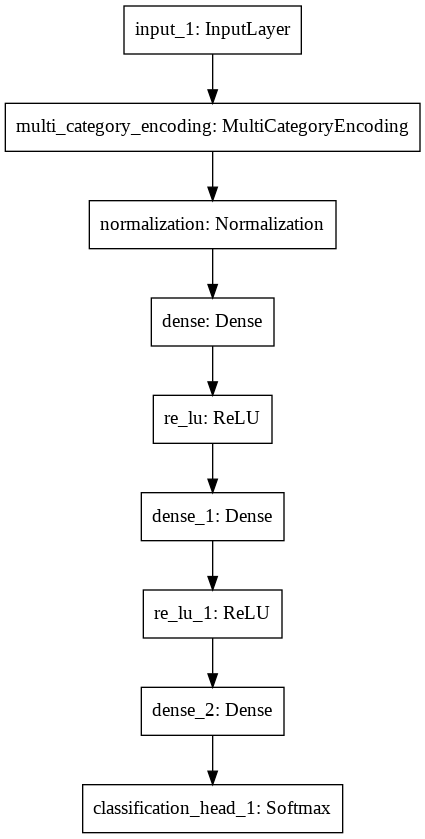

In [8]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='../Models/AWGN_Model.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating Model

#### Training the Model

In [9]:
AWGN_Model.fit(X_Train, y_Train, epochs=20, batch_size=768, validation_split=0.1,shuffle=True)

Epoch 1/20
36/36 [==============================] - 1s 8ms/step - loss: 0.6735 - accuracy: 0.6976 - val_loss: 0.3028 - val_accuracy: 0.9937
Epoch 2/20
36/36 [==============================] - 0s 3ms/step - loss: 0.4532 - accuracy: 0.8737 - val_loss: 0.4895 - val_accuracy: 0.7333
Epoch 3/20
36/36 [==============================] - 0s 3ms/step - loss: 0.4217 - accuracy: 0.8466 - val_loss: 0.5208 - val_accuracy: 0.7333
Epoch 4/20
36/36 [==============================] - 0s 3ms/step - loss: 0.4050 - accuracy: 0.8466 - val_loss: 0.5273 - val_accuracy: 0.7407
Epoch 5/20
36/36 [==============================] - 0s 3ms/step - loss: 0.3914 - accuracy: 0.8448 - val_loss: 0.5299 - val_accuracy: 0.7420
Epoch 6/20
36/36 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.8482 - val_loss: 0.5281 - val_accuracy: 0.7553
Epoch 7/20
36/36 [==============================] - 0s 4ms/step - loss: 0.3662 - accuracy: 0.8507 - val_loss: 0.5273 - val_accuracy: 0.7797
Epoch 8/20
36/36 [==

#### Evaluate the Model

Evaluating Model
938/938 [==============================] - 2s 2ms/step - loss: 0.8863 - accuracy: 0.7078
SNR: 5 Accuracy: 0.7078333497047424
938/938 [==============================] - 2s 2ms/step - loss: 0.5391 - accuracy: 0.7964
SNR: 10 Accuracy: 0.7964333295822144
938/938 [==============================] - 2s 2ms/step - loss: 0.3874 - accuracy: 0.8680
SNR: 15 Accuracy: 0.8679666519165039
938/938 [==============================] - 2s 2ms/step - loss: 0.3075 - accuracy: 0.8983
SNR: 20 Accuracy: 0.8982999920845032
938/938 [==============================] - 2s 2ms/step - loss: 0.2660 - accuracy: 0.9083
SNR: 25 Accuracy: 0.9082666635513306
938/938 [==============================] - 2s 2ms/step - loss: 0.2499 - accuracy: 0.9156
SNR: 30 Accuracy: 0.9156000018119812


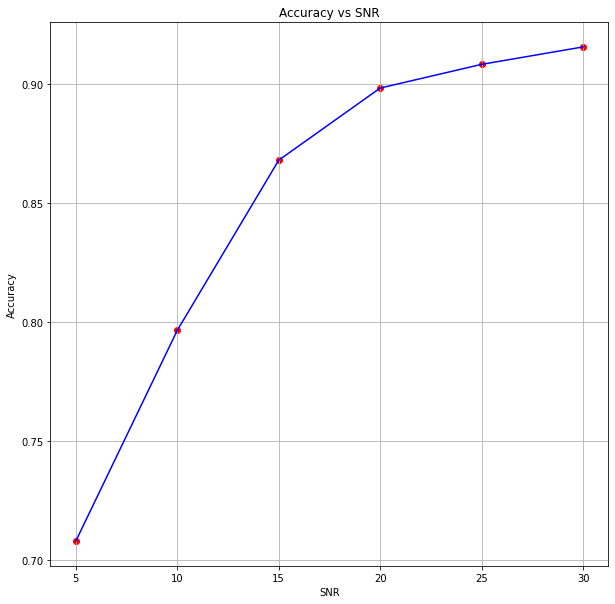

In [10]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracy.jpg")

#### Save Model

In [11]:
AWGN_Model.save("../Models/AWGN.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [12]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

#### Creating a CNN Classifier

In [13]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 18s]
val_loss: 0.0031145154498517513

Best val_loss So Far: 0.0031145154498517513
Total elapsed time: 00h 00m 18s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1154 - accuracy: 0.9797
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3831 - accuracy: 0.8641
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4768 - accuracy: 0.9259
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4700 - accuracy: 0.8983
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3396 - accuracy: 0.9366
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

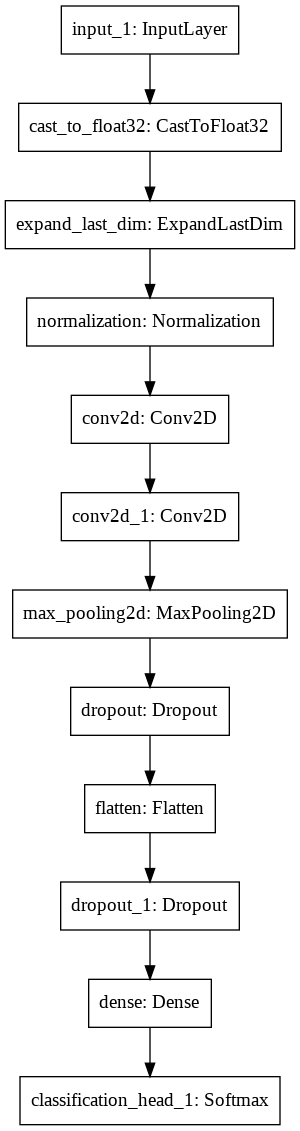

In [14]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=2.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [15]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.1242 - accuracy: 0.9730 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/20
657/657 [==============================] - 3s 4ms/step - loss: 1.8966e-04 - accuracy: 1.0000 - val_loss: 1.7069e-04 - val_accuracy: 1.0000
Epoch 3/20
657/657 [==============================] - 3s 4ms/step - loss: 6.5751e-05 - accuracy: 1.0000 - val_loss: 6.2464e-05 - val_accuracy: 1.0000
Epoch 4/20
657/657 [==============================] - 3s 4ms/step - loss: 3.7975e-05 - accuracy: 1.0000 - val_loss: 2.5391e-05 - val_accuracy: 1.0000
Epoch 5/20
657/657 [==============================] - 3s 4ms/step - loss: 2.6375e-05 - accuracy: 1.0000 - val_loss: 1.5735e-05 - val_accuracy: 1.0000
Epoch 6/20
657/657 [==============================] - 3s 4ms/step - loss: 1.6620e-05 - accuracy: 1.0000 - val_loss: 8.3446e-06 - val_accuracy: 1.0000
Epoch 7/20
657/657 [==============================] - 3s 4ms/step - loss: 8.0938e-04 - accuracy: 0.9997 - va

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 1.9950e-05 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.9834e-07 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 5.9986e-08 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.1419e-07 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 2.8148e-07 - accuracy: 1.0000
SNR: 25 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 5.7411e-08 - accuracy: 1.0000
SNR: 30 Accuracy: 1.0


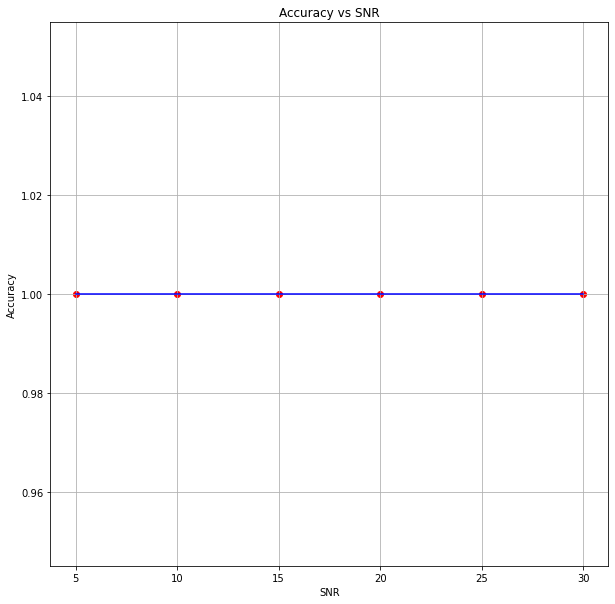

In [16]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=2.jpg")

#### Save CNN Model

In [17]:
Rayleigh_Model.save("../Models/Rayleigh_L=2.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [18]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

#### Creating a CNN Classifier

In [19]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 16s]
val_loss: 0.0013457676395773888

Best val_loss So Far: 0.0013457676395773888
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0774 - accuracy: 0.9813
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4971 - accuracy: 0.9297
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.7571 - accuracy: 0.8779
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3790 - accuracy: 0.9230
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5137 - accuracy: 0.9293
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

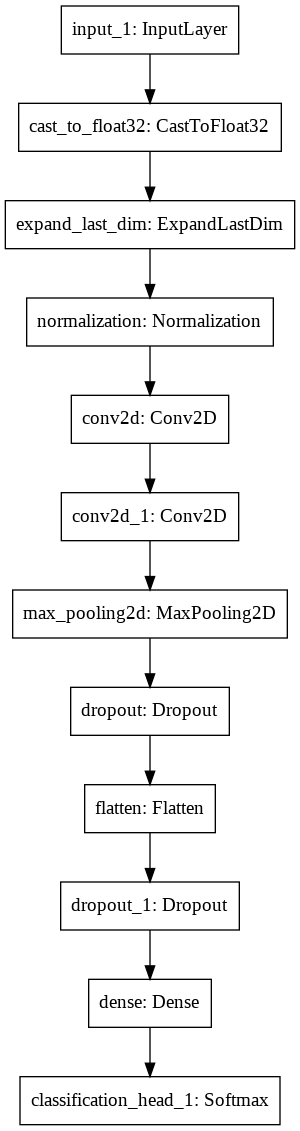

In [20]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=3.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [21]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.1658 - accuracy: 0.9730 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/20
657/657 [==============================] - 2s 4ms/step - loss: 2.4741e-04 - accuracy: 1.0000 - val_loss: 1.9402e-04 - val_accuracy: 1.0000
Epoch 3/20
657/657 [==============================] - 3s 4ms/step - loss: 1.1555e-04 - accuracy: 1.0000 - val_loss: 8.9312e-05 - val_accuracy: 1.0000
Epoch 4/20
657/657 [==============================] - 3s 4ms/step - loss: 4.1809e-05 - accuracy: 1.0000 - val_loss: 3.4560e-05 - val_accuracy: 1.0000
Epoch 5/20
657/657 [==============================] - 3s 4ms/step - loss: 2.1661e-05 - accuracy: 1.0000 - val_loss: 1.9691e-05 - val_accuracy: 1.0000
Epoch 6/20
657/657 [==============================] - 3s 4ms/step - loss: 5.7917e-05 - accuracy: 1.0000 - val_loss: 1.2966e-05 - val_accuracy: 1.0000
Epoch 7/20
657/657 [==============================] - 3s 4ms/step - loss: 9.5753e-06 - accuracy: 1.0000 - va

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 2.6142e-06 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
469/469 [==============================] - 1s 3ms/step - loss: 1.9089e-08 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 3ms/step - loss: 7.7962e-09 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.8942e-09 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 2.6067e-09 - accuracy: 1.0000
SNR: 25 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.9232e-09 - accuracy: 1.0000
SNR: 30 Accuracy: 1.0


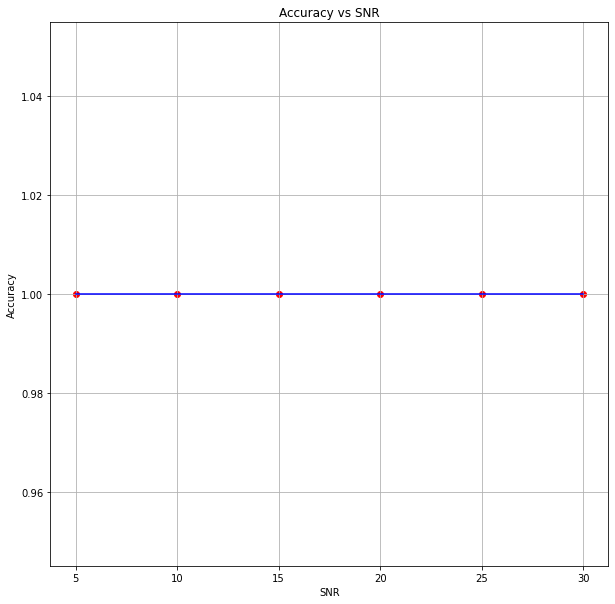

In [22]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=3.jpg")

#### Save CNN Model

In [23]:
Rayleigh_Model.save("../Models/Rayleigh_L=3.h5")

## CNN Model for Rayleigh Data

This part of the code is written to verify the results with CNN.

In [24]:
def CreateCNNModel():
    tf.keras.backend.clear_session()
    In = Input(shape=(100,2,1))
    x = Conv2D(filters=64,kernel_size=(3,1),activation='relu')(In)
    x = Conv2D(filters=16,kernel_size=(3,2),activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    Ou = Dense(3,activation='softmax')(x)

    model = Model(In,Ou)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["acc"])

    return model

### Rayleigh Fading of Channel Length = 2

Data Generation

In [25]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [26]:
CNNModel2 = CreateCNNModel()
CNNModel2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [27]:
CNNModel2.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.2174 - acc: 0.8895 - val_loss: 5.7002e-04 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 4ms/step - loss: 0.0041 - acc: 0.9982 - val_loss: 2.4866e-04 - val_acc: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0020 - acc: 0.9991 - val_loss: 5.3911e-04 - val_acc: 1.0000
Epoch 4/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0024 - acc: 0.9996 - val_loss: 3.3499e-05 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 3ms/step - loss: 1.9287e-04 - acc: 1.0000 - val_loss: 2.1076e-04 - val_acc: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 4ms/step - loss: 0.0099 - acc: 0.9966 - val_loss: 8.9368e-06 - val_acc: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 4.0495e-05 - acc: 1.0000 - val_loss: 2.9057e-06 - val_acc: 1.0000
Epoch 8/25
704/704 [====================

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 0.0016 - acc: 0.9995
SNR: 5 Accuracy: 0.9994666576385498
469/469 [==============================] - 1s 2ms/step - loss: 0.0011 - acc: 0.9998
SNR: 10 Accuracy: 0.9998000264167786
469/469 [==============================] - 1s 2ms/step - loss: 4.5775e-04 - acc: 0.9999
SNR: 15 Accuracy: 0.9998666644096375
469/469 [==============================] - 1s 2ms/step - loss: 4.8612e-05 - acc: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 0.0012 - acc: 0.9997
SNR: 25 Accuracy: 0.9997333288192749
469/469 [==============================] - 1s 2ms/step - loss: 2.3603e-09 - acc: 1.0000
SNR: 30 Accuracy: 1.0


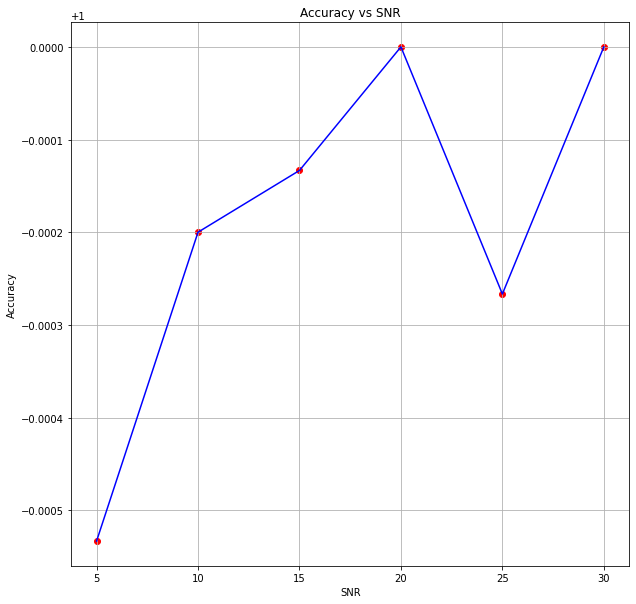

In [28]:
EvaluateData(CNNModel2, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=2.jpg")

### Rayleigh Fading of Channel Length = 3

Data Generation

In [29]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [30]:
CNNModel3 = CreateCNNModel()
CNNModel3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [31]:
CNNModel3.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.1795 - acc: 0.9040 - val_loss: 4.5073e-04 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0039 - acc: 0.9985 - val_loss: 6.7776e-05 - val_acc: 1.0000
Epoch 3/25
704/704 [==============================] - 3s 4ms/step - loss: 0.0020 - acc: 0.9996 - val_loss: 1.8062e-05 - val_acc: 1.0000
Epoch 4/25
704/704 [==============================] - 3s 4ms/step - loss: 2.0208e-05 - acc: 1.0000 - val_loss: 6.7268e-06 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 4ms/step - loss: 1.1672e-05 - acc: 1.0000 - val_loss: 3.3490e-06 - val_acc: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 3ms/step - loss: 6.0291e-06 - acc: 1.0000 - val_loss: 1.7994e-06 - val_acc: 1.0000
Epoch 7/25
704/704 [==============================] - 3s 4ms/step - loss: 6.0678e-06 - acc: 1.0000 - val_loss: 1.1505e-06 - val_acc: 1.0000
Epoch 8/25
704/704 [============

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 4.5565e-04 - acc: 0.9999
SNR: 5 Accuracy: 0.9999333620071411
469/469 [==============================] - 1s 2ms/step - loss: 4.3197e-05 - acc: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 9.4308e-05 - acc: 0.9999
SNR: 15 Accuracy: 0.9999333620071411
469/469 [==============================] - 1s 2ms/step - loss: 7.6633e-05 - acc: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 2.7324e-04 - acc: 0.9999
SNR: 25 Accuracy: 0.9999333620071411
469/469 [==============================] - 1s 2ms/step - loss: 1.5497e-09 - acc: 1.0000
SNR: 30 Accuracy: 1.0


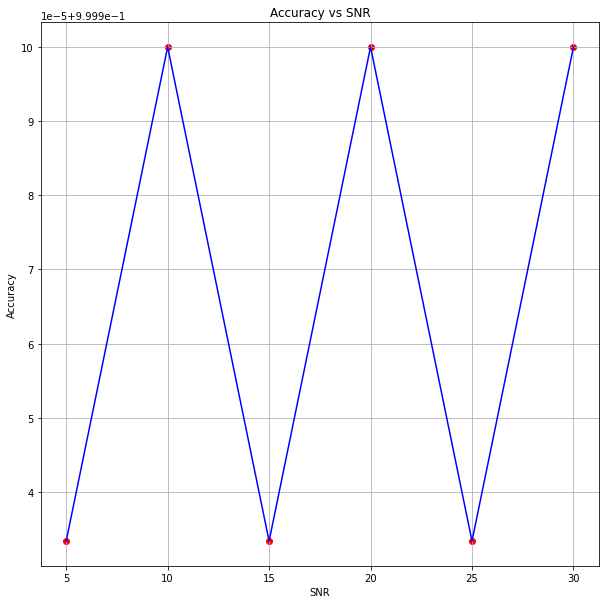

In [32]:
EvaluateData(CNNModel3, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=3.jpg")